In [102]:
# This is not my original work!  
# I make no claims, other than to stand on the shoulders of other geniuses.

# I am just recreating the fabulous documentation found at https://www.nakka-rocketry.net/.  If you like model rocketry, and want to learn more about DIY motors, this page goes deep into the math and theory.

Text(0, 0.5, 'Kn')

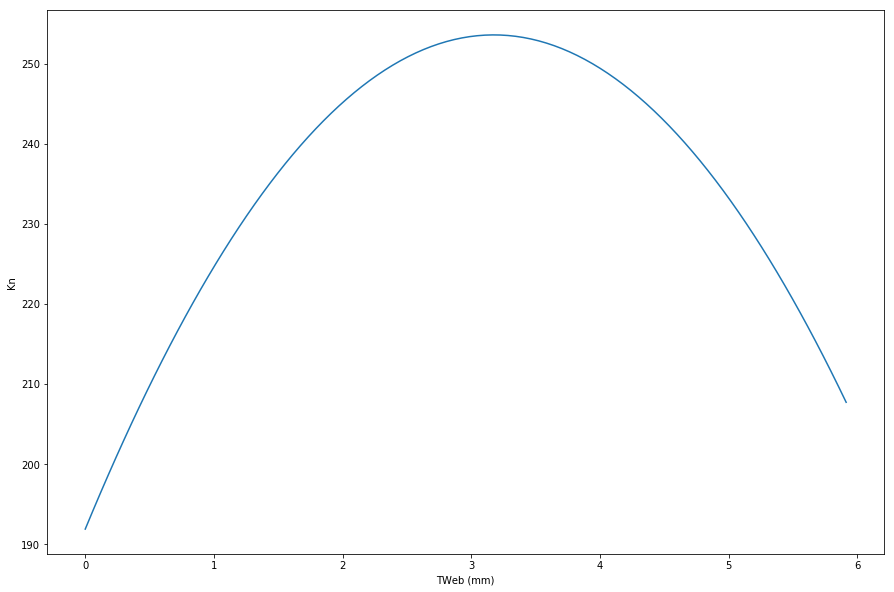

In [103]:
import numpy as np
from IPython.display import display, Math
import math
import matplotlib.pyplot as plt
import scipy.optimize as opt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import pandas as pd

%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 10]

#some handy functions
def circleArea(do,di=0):
    return (math.pi/4) * (do**2-di**2)

def cylinderVolume(h,do,di=0):
    return circleArea(do,di) * h

mpa_to_psi = 145.038

#User variables
#outer diameter of grain
Do = 15.
#inner diameter of grain (core size)
Di = 3.175
#length of grain
L = 25.4
#Propellant type
Ptype="KNSU"
#Target MEOP
Ptar=850/mpa_to_psi
#combustion efficiency
nuC=.95

#read in fuel specs
df=pd.read_csv('fuelspecs.csv', sep=',', header=0)
Pdf=df.loc[df['name'] == Ptype]

# calculate max kn with least squares polynomial
coeff=Pdf[Pdf.columns[-6:]].values[0]
KnMax = np.polyval(coeff,Ptar)

Tweb_0 = (Do - Di) / 2

# x is amount burned
x = np.linspace(0,Tweb_0,100)

# find max Ab
Abs = circleArea(Do,Di+2*x)*2 + math.pi*(Di+2*x)*(L-2*x)
AbMax=np.amax(Abs)

Ato = AbMax/KnMax
Kn = Abs/Ato
plt.plot(x,Kn)   
plt.xlabel('TWeb (mm)')
plt.ylabel('Kn')

In [104]:
#Constants calculated from 
# Universal Gas Constant in m^3 Pa/Mol-K - > m^3-Mpa/Mol-K
Rprime = 8314.
# effective molecular weight in kg/Mol  
M = Pdf.M.values[0]
# ratio of specific heats
k = Pdf.k.values[0]   
# K Ideal combustion temperature
To = Pdf.To.values[0]
# K Actual combustion temperature
To_act = To * nuC
# ambient atmospheric pressure (MPa)
Patm = .101
# Ideal propellent density (g/cm^3 -> kg /m^3 )
rho_p = Pdf.rho_p.values[0] * 1000 

# pressure exponent (mm/s)
n = 0.319
# burn rate coefficient (psi -> m/sec-Pa^n)
a = 0.0665 * (1/39.37) * (1/6895**n)



The steady-state chamber pressure $P_o(K_n)$ is given by:

$$\Large P_o=\left[K_n \frac{a \rho_p}{\sqrt{\frac{k}{R T_o}\left(\frac{2}{k+1}\right)^\frac{k+1}{k-1}}}\right]^\frac{1}{1-n}$$

Text(0, 0.5, 'Pressure (psi)')

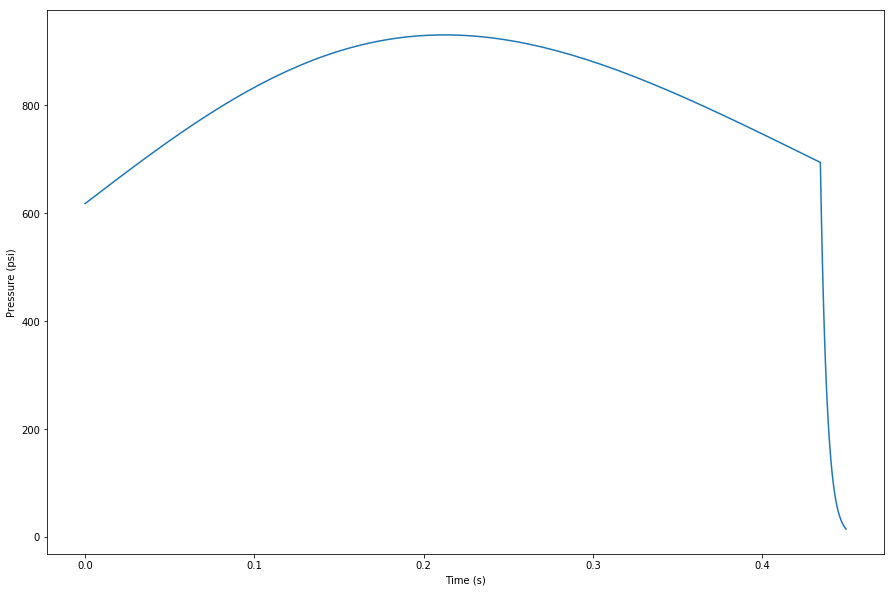

In [105]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 10]
# break this up a bit
R = Rprime/M

Po = np.power(((Kn*a*rho_p)/math.sqrt((k/(To_act*R))*(np.power((2./(k+1.)),((k+1.)/(k-1.))))  )),(1./(1.-n)))
Po_psi=mpa_to_psi*Po/1000000.

# calculate falloff
Pbo = Po[-1]

cstar = math.sqrt((R*To)/(k*((2/(k+1))**((k+1)/(k-1)))))

Uo = cylinderVolume(L/1000,Do/1000);
def Pb(t): return (Pbo * np.exp(t * -R * To * Ato/(1000**2 * Uo * cstar))) - Patm*1000000.
end_t = opt.newton(Pb,0) 

x2 = np.linspace(0,end_t)
Px2 = Pb(x2) + Patm*1000000
Px2_psi=mpa_to_psi*Px2/1000000

#burn rate over Po array
r = a*Po**n

#calculate delta time per mm burned
time_intervals=x/(1000*r)
x2 = x2 + time_intervals[-1]

time_intervals = np.concatenate([time_intervals,x2]) 
Po = np.concatenate([Po,Px2])
Po_psi = np.concatenate([Po_psi,Px2_psi])

plt.plot(time_intervals, Po_psi)
plt.xlabel('Time (s)')
plt.ylabel('Pressure (psi)')

The Thrust Coefficient $C_f$ is given by:

$$\Large C_f = \sqrt{\frac{2 k^2}{k-1}\left(\frac{2}{k+1}\right)^\frac{k+1}{k-1}\left[1-\left(\frac{P_e}{P_o}\right)^\frac{k-1}{k}\right]} + \frac{\left(P_e-P_a\right) A_e}{P_o A*}$$


In [106]:
# calculate the constant term
k=1.044
Pa=Patm*1000000
Pe=Pa
Ae=24.6
Astar=Ato/(1000**2)
Vg=cylinderVolume(L,Do,Di)
mgrain = rho_p*Vg/(1000**3)

Ck = (2*(math.pow(k,2)/(k-1.))*(math.pow((2./(k+1.)),((k+1.)/(k-1.)))))

# ignore the second term for now
NuCf = np.sqrt(Ck * (1.-np.power((Pe/Po),((k-1.)/(k)))))

F=NuCf * Astar * Po
zeroStart = np.array([0.])
Itd =  F * np.diff(np.append(zeroStart,time_intervals))

It = np.sum(Itd)
Isp = It/(9.806*mgrain)
print ('Total Impulse = {:.2f} N-sec'.format(It))
print ('Isp = {:.2f} sec'.format(Isp))

Total Impulse = 12.94 N-sec
Isp = 162.92 sec


Text(0, 0.5, 'Thrust (N)')

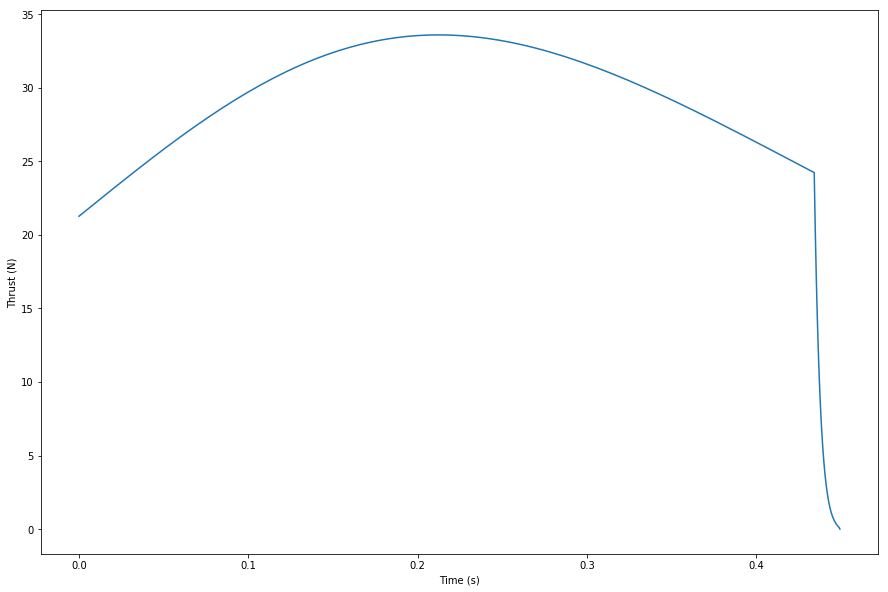

In [107]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 10]
plt.plot(time_intervals, F)
plt.xlabel('Time (s)')
plt.ylabel('Thrust (N)')